## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the basics of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

The value of x: 
 3563
How my data lasted: 
 0.9801411533125001
Number of counts per TDC channel with FPGA=0:


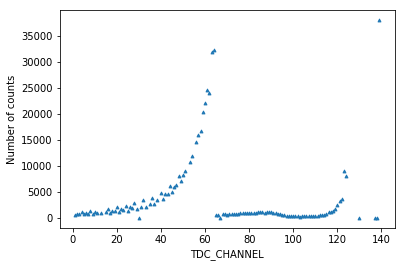

Number of counts per TDC channel with FPGA=1:


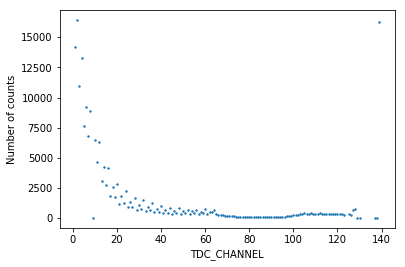

The most 3 TDC noisy channels: 
 139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64


Number of unique orbits: 
 11001
Number of unique orbits with TDC_CHANNEL = 139: 
 10976


In [92]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

########## 1. ##########
file_name = "../data/data_000637.txt"
data=pd.read_csv(file_name)

# To read the first N elements of my data:
# N = 3000
# data_N = pd.read_csv(file_name,nrows=N)
# print("all data from 0 to N: \n", data[0:N])

########## 2. ##########
x = np.max(data['BX_COUNTER'])
print("The value of x: \n", x)

########## 3. & 4. ##########
data['TIMENS'] = data['TDC_MEAS']*25/30+data['BX_COUNTER']*25+data['ORBIT_CNT']*(x*25)
max_timens = np.max(data['TIMENS'])
min_timens = np.min(data['TIMENS'])
data_lasted = max_timens - min_timens
print("How my data lasted: \n", data_lasted*1e-9)

########## 5. ##########
rdn_vec = np.random.randint(2,size=(data.shape[0],1))
data['HEAD'] = rdn_vec
#print(data)

########## 6. ##########
one_head = pd.DataFrame(data.loc[data['HEAD'] == 1])
#print(one_head)

########## 7. ##########
fpga0_data = pd.DataFrame(one_head.loc[data['FPGA'] == 0])
fpga1_data = pd.DataFrame(one_head.loc[data['FPGA'] == 1])
#print(fpga0_data)

# for fpga0
count_tdc0 = fpga0_data['TDC_CHANNEL'].value_counts()

# Save the values of count_tdc to plot the data
y = count_tdc0.values
x = count_tdc0.keys()

%matplotlib inline
print("Number of counts per TDC channel with FPGA=0:")
plt.scatter(x,y,marker='^',s=8,label='FPGA=0')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Number of counts')
plt.show()

#for fpga1
count_tdc1 = fpga1_data['TDC_CHANNEL'].value_counts()

# Save the values of count_tdc to plot the data
y = count_tdc1.values
x = count_tdc1.keys()

%matplotlib inline
print("Number of counts per TDC channel with FPGA=1:")
plt.scatter(x,y,marker='.',s=8,label='FPGA=1')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Number of counts')
plt.show()

########## 8. ##########
count_tdc = data['TDC_CHANNEL'].value_counts()
top3_tdc = count_tdc.groupby(count_tdc.keys()).nlargest(3)
print("The most 3 TDC noisy channels: \n", top3_tdc[:3])
print("\n")

########## 9. ##########
print("Number of unique orbits: \n", data['ORBIT_CNT'].nunique())

tdc_139 = data.loc[data['TDC_CHANNEL'] == 139, 'ORBIT_CNT']
print("Number of unique orbits with TDC_CHANNEL = 139: \n",tdc_139.nunique())

